In [ ]:
# Add the directory containing api_connection.py to the system path
import sys
import os
from collections import Counter
import numpy as np
from pathlib import Path
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import DensityMatrix, partial_trace, entropy, Statevector, shannon_entropy
from qiskit_experiments.library import StateTomography
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
sys.path.append(str(Path.cwd() / "bachelor_thesis"))
from api_connection import QiskitService
from qiskit_aer import AerSimulator  # For simulation comparison


In [ ]:
#backend = AerProvider().get_backend("qasm_simulator")


service  = QiskitService(str(Path.cwd() / ".env"))
backend = service.get_least_busy_backend()

Connected to IBM Quantum.


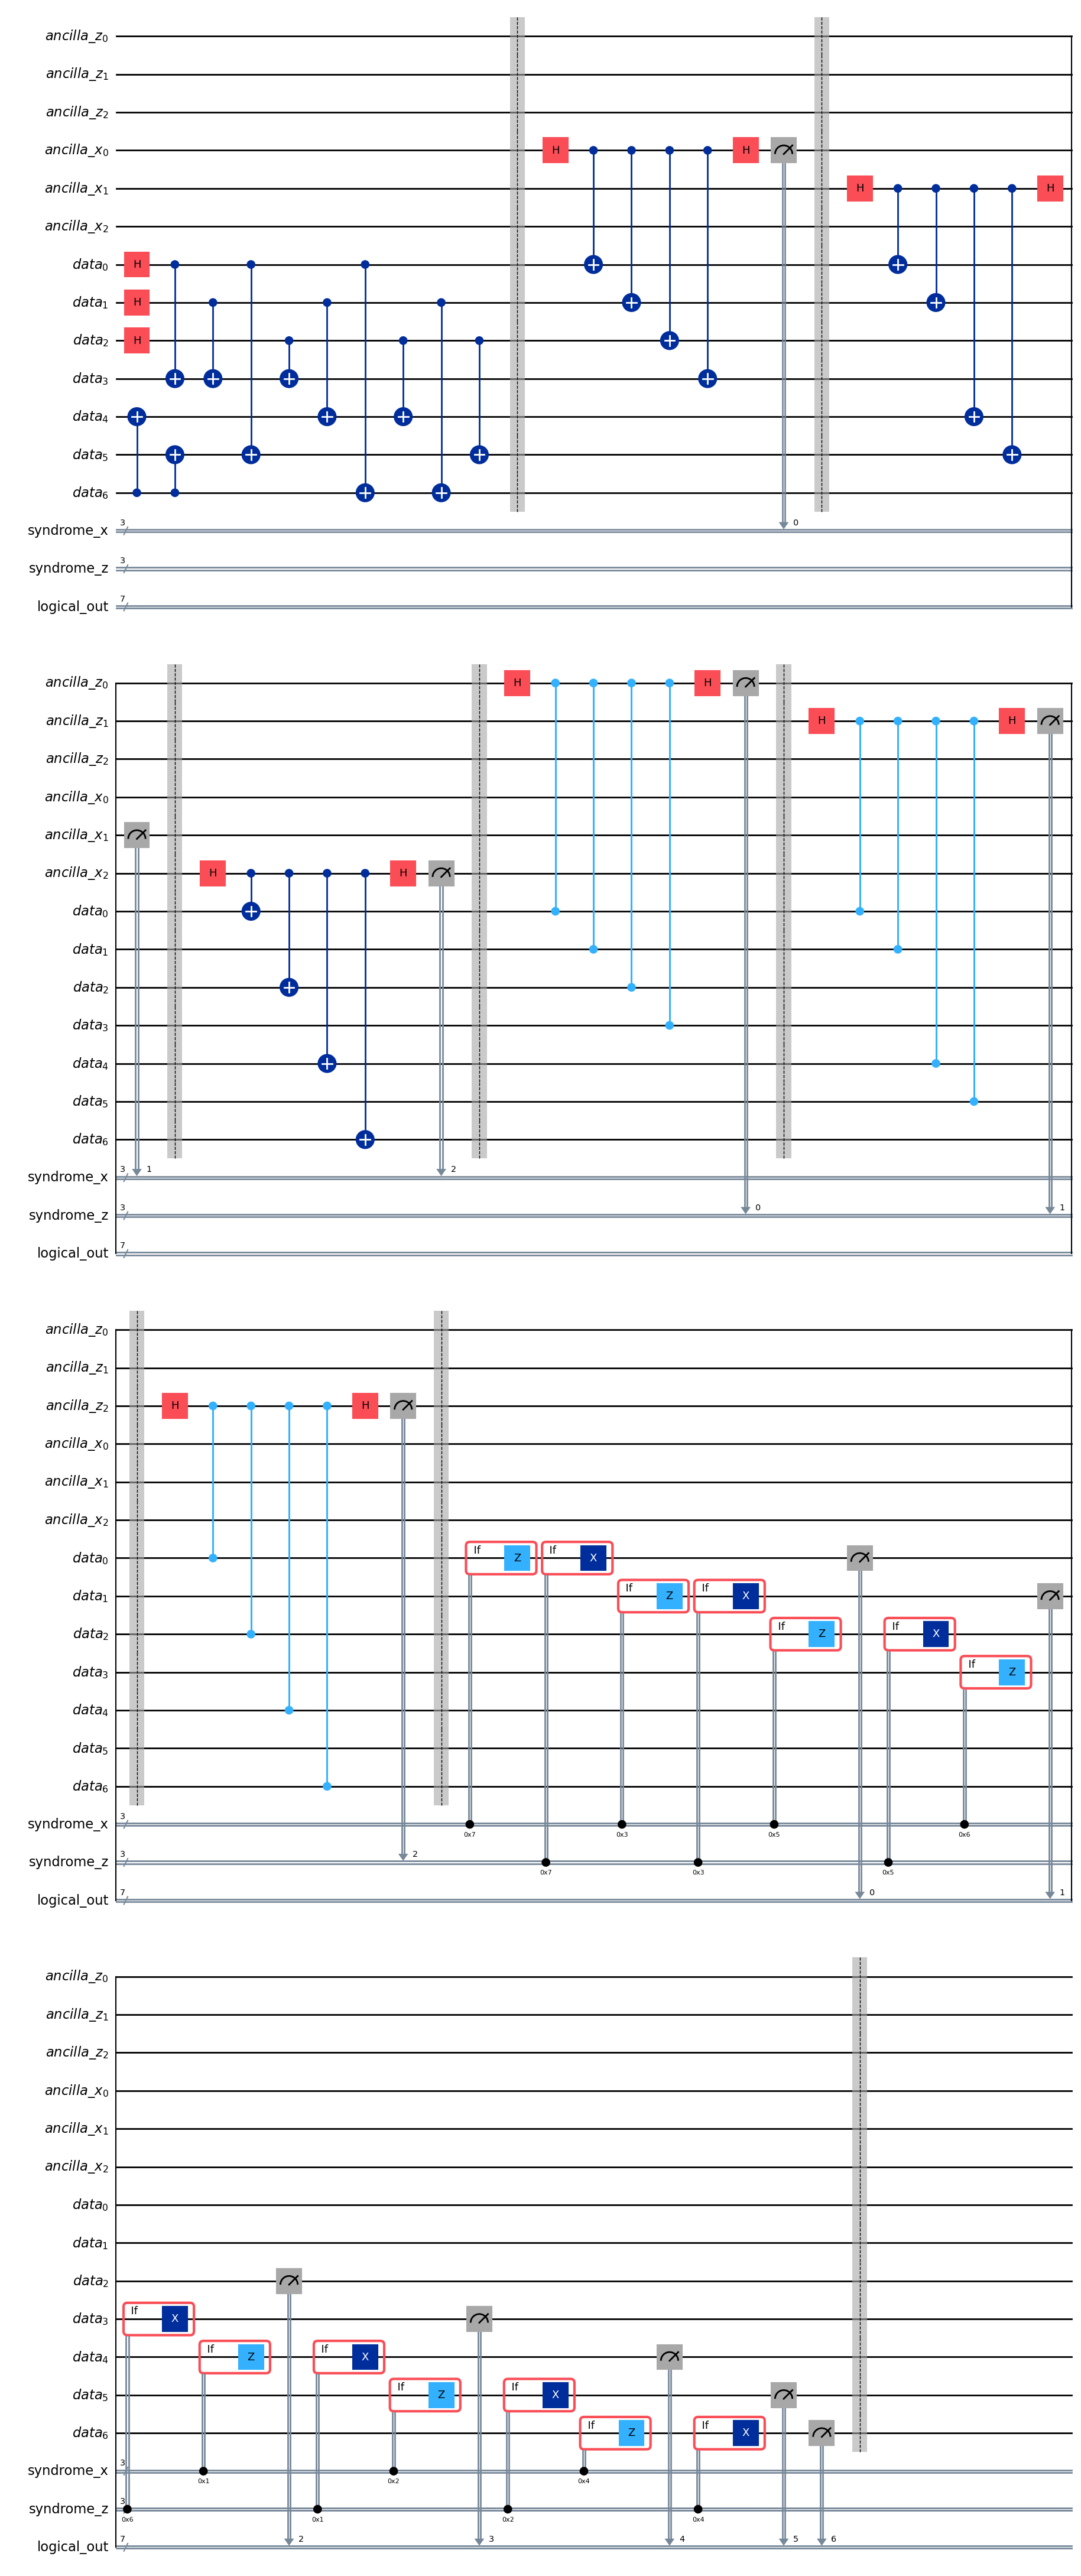

In [ ]:
barrierBit = 0
data = QuantumRegister(7, 'data')
ancilla_x = QuantumRegister(3, 'ancilla_x')
ancilla_z = QuantumRegister(3, 'ancilla_z')
syndrome_x = ClassicalRegister(3, 'syndrome_x')
syndrome_z = ClassicalRegister(3, 'syndrome_z')
logical_out = ClassicalRegister(7, 'logical_out')

circuit = QuantumCircuit(ancilla_z, ancilla_x, data, syndrome_x, syndrome_z, logical_out)

# Encoding for |0_L>
circuit.h(data[0])
circuit.h(data[1])
circuit.h(data[2])
circuit.cx(data[6], data[4])

circuit.cx(data[6], data[5])
circuit.cx(data[0], data[3])
circuit.cx(data[1], data[3])
circuit.cx(data[0], data[5])
circuit.cx(data[2], data[3])
circuit.cx(data[1], data[4])
circuit.cx(data[0], data[6])
circuit.cx(data[2], data[4])
circuit.cx(data[1], data[6])
circuit.cx(data[2], data[5])


#circuit.x(data[0])
#circuit.z(data[0])

stabilizers = [(0,1,2,3), (0,1,4,5), (0,2,4,6)]
for i, (q0, q1, q2, q3) in enumerate(stabilizers):
    circuit.barrier()
    circuit.h(ancilla_x[i])
    # Reverse the control-target order for the CNOT gates:
    circuit.cx(ancilla_x[i], data[q0])
    circuit.cx(ancilla_x[i], data[q1])
    circuit.cx(ancilla_x[i], data[q2])
    circuit.cx(ancilla_x[i], data[q3])
    circuit.h(ancilla_x[i])
    circuit.measure(ancilla_x[i], syndrome_x[i])
    circuit.barrier()
    circuit.h(ancilla_z[i])
    circuit.cz(data[q0], ancilla_z[i])
    circuit.cz(data[q1], ancilla_z[i])
    circuit.cz(data[q2], ancilla_z[i])
    circuit.cz(data[q3], ancilla_z[i])
    circuit.h(ancilla_z[i])
    circuit.measure(ancilla_z[i], syndrome_z[i])

# Define syndrome-to-data qubit mappings for error corrections.
# Each tuple is (syndrome pattern, data qubit index).
corrections = [(0b111, 0), (0b011, 1), (0b101, 2), (0b110, 3),
               (0b001, 4), (0b010, 5), (0b100, 6)]


# Correct for phase-flip (Z) errors using the syndrome from the X stabilizers.
for pattern, qubit in corrections:
    with circuit.if_test((syndrome_x, pattern)):
        circuit.z(data[qubit])
    with circuit.if_test((syndrome_z, pattern)):
        circuit.x(data[qubit])


for i in range(7):
    circuit.measure(data[i], logical_out[i])
circuit.barrier()


circuit.draw(output='mpl')

In [4]:
# Simulation parameters
simulator = AerSimulator()  # Try default simulator first
NUM_SHOTS = 5000
classic_job = simulator.run(circuit, shots=NUM_SHOTS)
classic_result = classic_job.result()
counts = classic_result.get_counts()
CodeWord = list(counts.keys())

print(CodeWord)

['1101001 000 000', '1010101 000 000', '0000000 000 000', '1100110 000 000', '0110011 000 000', '0001111 000 000', '0111100 000 000', '1011010 000 000']


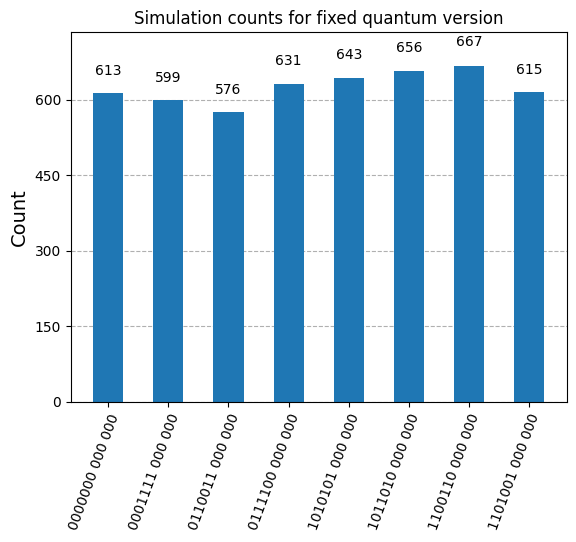

In [5]:
plot_histogram(classic_result.get_counts(), title='Simulation counts for fixed quantum version')

* Classic error correcting version down below

In [8]:
NUM_SHOTS = 3000
# Set up the preset pass manager with optimization level 0
preset_manager = generate_preset_pass_manager(backend)# optimization_level=3)
preset_circuit = preset_manager.run(circuit)

# Run the circuit using the Sampler
job = Sampler(mode=backend).run([(preset_circuit)], shots=NUM_SHOTS)
print(f"Job ID: {job.job_id()}, \n Job Status: {job.status()}")

Job ID: czv7mw3qnmvg008vj390, 
 Job Status: QUEUED


In [ ]:
# Get results
result = job.result()
pub_result = result[0]

# Print measurement counts
print(f"Counts for 'syndrome_x' (phase flips): {pub_result.data.syndrome_x.get_counts()}")
print(f"Counts for 'syndrome_z' (bit flips): {pub_result.data.syndrome_z.get_counts()}")
print(f"Counts for 'logical_out' (data qubits): {pub_result.data.logical_out.get_counts()}")

Counts for 'syndrome_x' (phase flips): {'010': 356, '101': 393, '110': 338, '011': 415, '001': 398, '111': 411, '000': 356, '100': 333}
Counts for 'syndrome_z' (bit flips): {'101': 394, '100': 389, '110': 390, '001': 375, '111': 357, '010': 386, '011': 358, '000': 351}
Counts for 'logical_out' (data qubits): {'1010100': 16, '1011101': 20, '1110000': 34, '1011111': 22, '0010100': 42, '0010001': 36, '0000010': 20, '1110100': 15, '0100111': 15, '1010101': 26, '0100110': 32, '0000100': 48, '0110111': 29, '0000000': 36, '1110111': 22, '1010001': 24, '0011011': 24, '1000001': 31, '1001010': 19, '0111100': 20, '1000101': 28, '0001011': 32, '1101101': 22, '0001101': 26, '1000110': 26, '1011110': 12, '0010010': 29, '0010000': 17, '0111101': 11, '1010111': 21, '0010111': 21, '0011111': 22, '0100100': 34, '1010011': 18, '0000101': 27, '0011101': 18, '0001000': 23, '0001001': 31, '0011001': 27, '0010110': 27, '1001011': 16, '0010011': 33, '1110110': 18, '0101101': 17, '1100000': 36, '1001101': 26,

In [ ]:
service.get_usage()

{'period': {'start': '2025-04-01T00:00:00.000Z',
  'end': '2025-04-30T23:59:59.999Z'},
 'byInstance': [{'instance': 'ibm-q/open/main',
   'quota': 600,
   'usage': 172,
   'pendingJobs': 1,
   'maxPendingJobs': 3}]}

In [ ]:
#print the type of the result logical out
print(type(pub_result.data.logical_out))

<class 'qiskit.primitives.containers.bit_array.BitArray'>


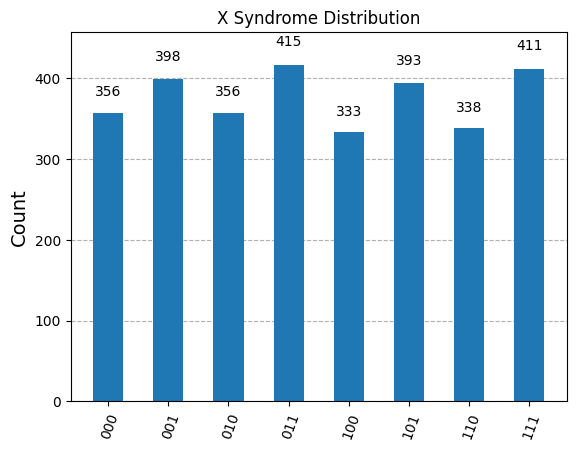

In [ ]:

# Optional: Visualize the syndrome distributions
plot_histogram(pub_result.data.syndrome_x.get_counts(), title="X Syndrome Distribution")

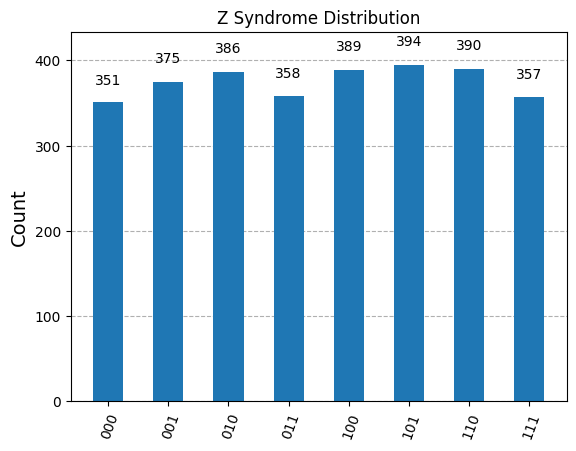

In [ ]:
plot_histogram(pub_result.data.syndrome_z.get_counts(), title="Z Syndrome Distribution")


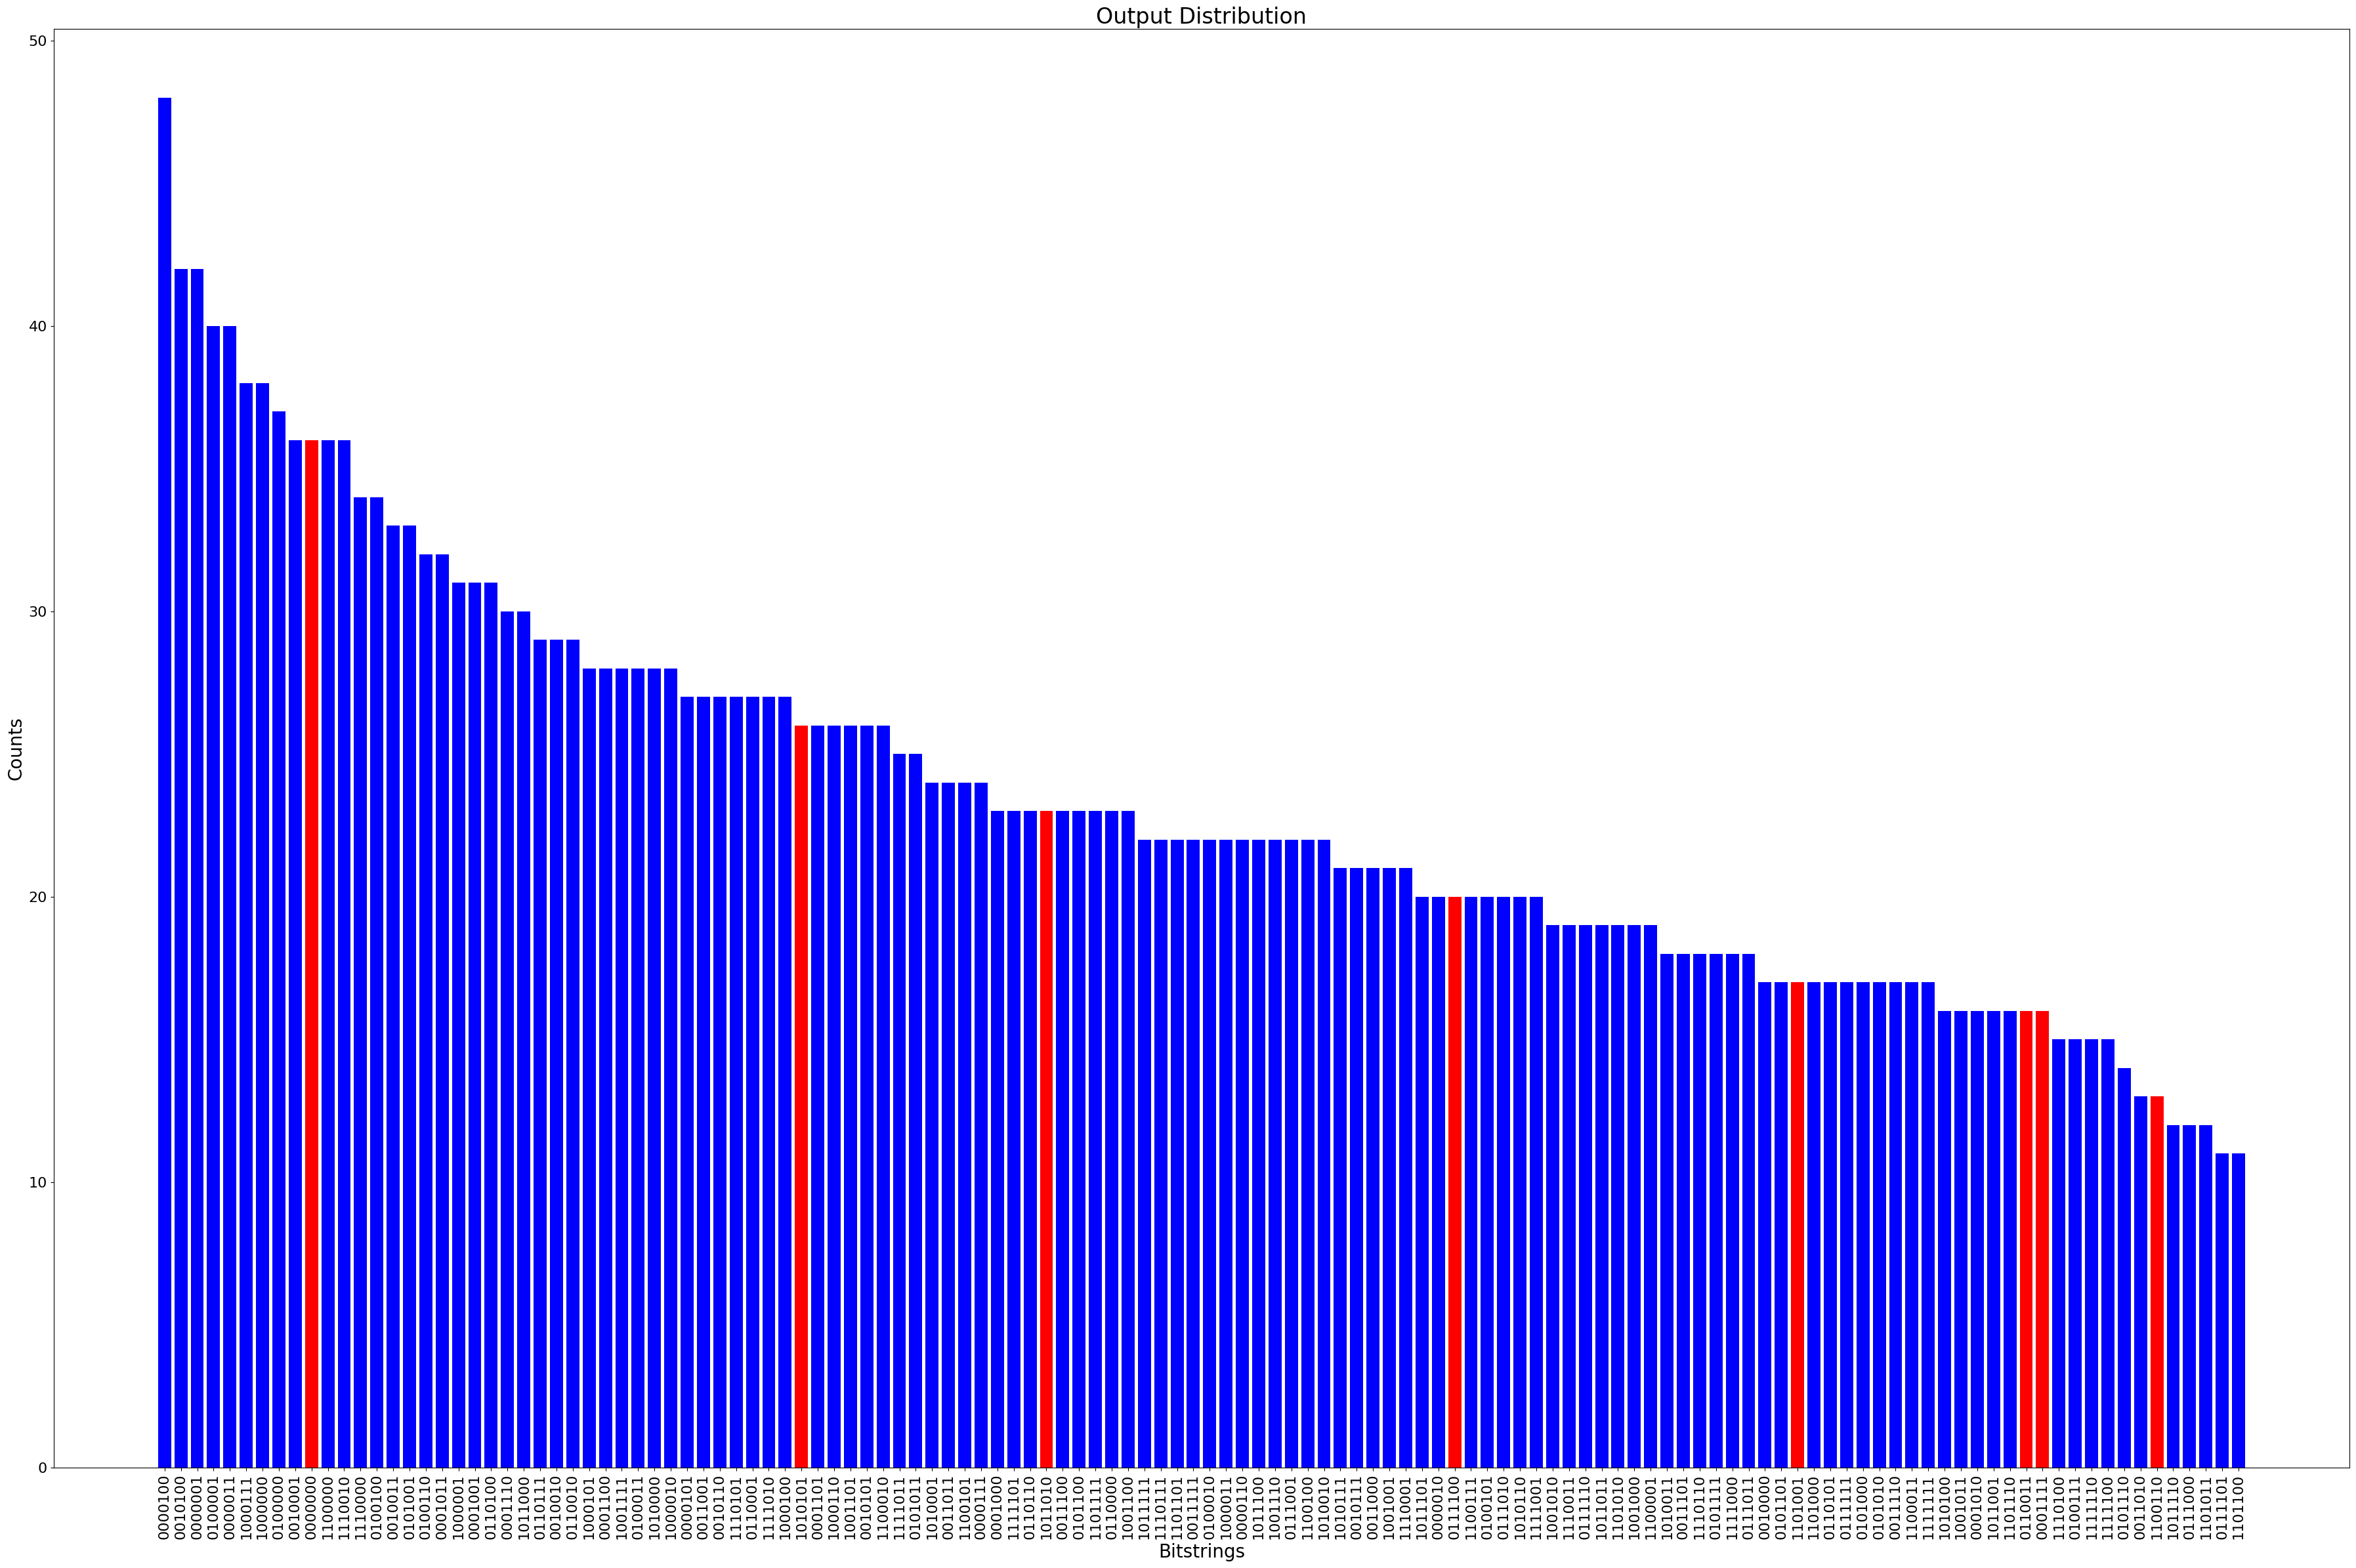

In [ ]:
import matplotlib.pyplot as plt

steane_code_logic_0 = {"0000000", "1010101", "0110011", "1100110", 
                       "0001111", "1011010", "0111100", "1101001"}

# Get the counts data
counts = pub_result.data.logical_out.get_counts()

# Sort the counts for better visualization
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

# Prepare data for plotting
keys = list(sorted_counts.keys())
values = list(sorted_counts.values())
colors = [
    "red" if key in steane_code_logic_0 
    else "blue" 
    for key in keys
]
# Create the bar chart
plt.figure(figsize=(36, 24))
plt.bar(keys, values, color=colors)

# Add labels and title
plt.xlabel("Bitstrings", fontsize=20)
plt.ylabel("Counts", fontsize=20)
plt.title("Output Distribution", fontsize=24)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the total counts for the desired states in steane_code_logic_0
desired_counts = sum(counts[key] for key in steane_code_logic_0 if key in counts)

# Print the result
print(f"Total counts for desired states in steane_code_logic_0: {desired_counts}")

# Calculate the percentage of desired states
percentage = (desired_counts / NUM_SHOTS) * 100
print(f"Percentage of desired states: {percentage:.2f}%")

# Calculate the number of distinct values encountered
distinct_values = len(counts)
print(f"Number of distinct values encountered: {distinct_values}")

Total counts for desired states in steane_code_logic_0: 167
Percentage of desired states: 5.57%
Number of distinct values encountered: 128


In [ ]:
# Convert logical_out BitArray to a probability vector

# Get counts from logical_out
logical_out_counts = pub_result.data.logical_out.get_counts()

# Calculate total shots
total_shots = sum(logical_out_counts.values())

# Create a probability vector
probability_vector = [count / total_shots for count in logical_out_counts.values()]

# Print the probability vector in a readable format
#print("Probability vector:")
#for i, prob in enumerate(probability_vector):
#    print(f"  Outcome {i + 1}: {prob:.6f}")

# Calculate and print the Shannon entropy
entropy_value = shannon_entropy(probability_vector)
print(f"\nShannon Entropy: {entropy_value:.6f}")


Shannon Entropy: 6.932548
